In [45]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Model

In [46]:
class Encoder(nn.Sequential):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        nn.Sequential.__init__(self,
            # Convolution 1 - input shape (1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            # Convolution 1 - input shape (32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            # dense - input shape (64, 7, 7) 
            # output dimension is 2 * z-dim (concat mean and variance vectors)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 2 * z_dim)
        )
    def forward(self, x):
        mean_variance = nn.Sequential.forward(self, x)
        mean, log_variance = mean_variance[..., :self.z_dim], mean_variance[..., self.z_dim:]
        # actually computes the log of the variance
        return mean, log_variance
class Decoder(nn.Module):
    def __init__(self, z_dim):
        nn.Module.__init__(self)
        self.linear = nn.Linear(z_dim, 64 * 7 * 7)
        self.conv = nn.Sequential(
            # transpose convolution 1 - input shape (64, 7, 7)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # transpose convolution 2 - input shape (32, 14, 14)
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # pixel-wise linear - input shape (16, 28, 28)
            nn.Conv2d(16, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # output shape (1, 28, 28)
        )
    def forward(self, z):
        x = self.linear(z).relu()
        x = x.reshape(-1, 64, 7, 7)
        return self.conv(x)
class VAE(nn.Module):
    def __init__(self, z_dim):
        nn.Module.__init__(self)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    def forward(self, x):
        # encode
        mean, variance_log = self.encoder(x)
        # sample from encoding
        if self.training:
            eps = torch.empty_like(variance_log).normal_()
            z = eps * (variance_log / 2).exp() + mean
        else:
            # in evaluation use the mean
            z = mean
        # decode from sample
        x_ = self.decoder(z)
        return x_, mean, variance_log

In [47]:
z_dim = 10
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
# create model and optimizer
vae = VAE(z_dim).to(device)
optim = torch.optim.Adam(vae.parameters())

Using device: cuda:0


## Training

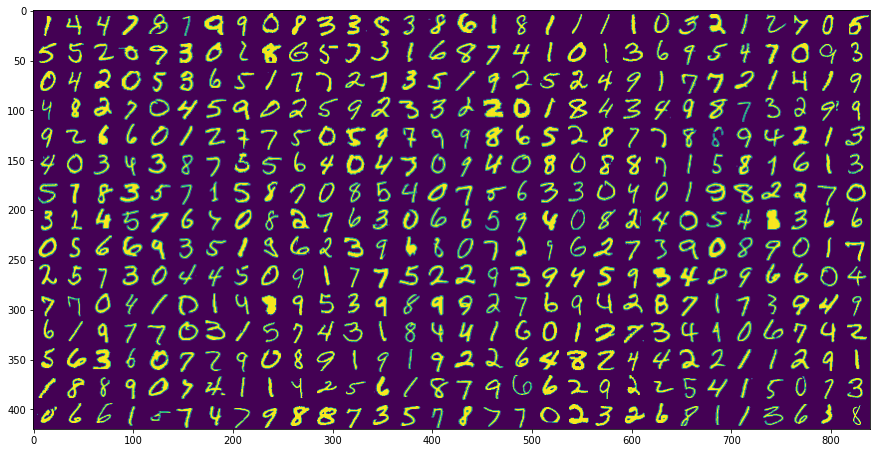

In [48]:
# load mnist data
mnist_train = MNIST('./data/', train=True, download=True, transform=ToTensor())
mnist_test = MNIST('./data/', train=False, download=True, transform=ToTensor())
# create dataloaders
train_loader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(mnist_test, shuffle=False, batch_size=64)
# visualize data
n, m = 15, 30
x = mnist_train.data[torch.randint(0, len(mnist_train), (n * m,)).long()]
x = x.numpy().reshape(n, m, 28, 28)
x = x.transpose(0, 2, 1, 3).reshape(n * 28, m * 28)
figsize(n, m)
figure()
imshow(x)
show()

Train:   0%|          | 0/1876 [00:00<?, ?it/s]

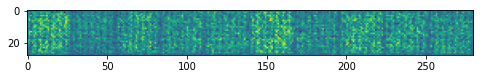

Train:  16%|█▌        | 299/1876 [00:04<00:20, 76.24it/s, r-loss=1.11e+4, kl-loss=599]

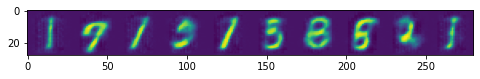

Train:  32%|███▏      | 600/1876 [00:08<00:17, 71.60it/s, r-loss=7.65e+3, kl-loss=613]

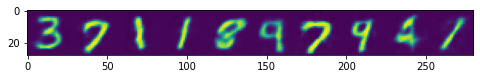

Train:  48%|████▊     | 899/1876 [00:12<00:12, 76.40it/s, r-loss=6.83e+3, kl-loss=613]

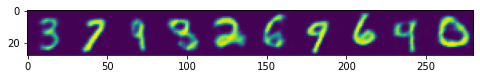

Train:  64%|██████▍   | 1199/1876 [00:16<00:08, 76.83it/s, r-loss=6.53e+3, kl-loss=633]

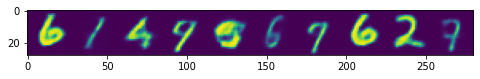

Train:  80%|███████▉  | 1499/1876 [00:20<00:04, 76.02it/s, r-loss=6.64e+3, kl-loss=658]

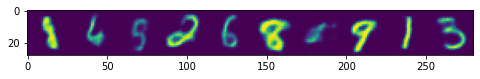

Train:  96%|█████████▌| 1799/1876 [00:24<00:01, 76.30it/s, r-loss=5.88e+3, kl-loss=637]

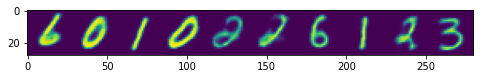

Train: 100%|██████████| 1876/1876 [00:25<00:00, 73.10it/s, r-loss=3.05e+3, kl-loss=323]


In [49]:
# training the auto-encoder
epochs, v_interval = 2, 300
beta = 0.2
# losses
r_losses, kl_losses = [], []
with tqdm(total=len(train_loader) * epochs) as pbar:
    pbar.set_description("Train", refresh=True)
    # train
    vae.train()
    for e in range(epochs):
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            # predict and compute loss
            x_, m, v_log = vae(x)
            r_l = F.binary_cross_entropy(x_, x, reduction='sum')
            kl_l = beta * (v_log.exp() + m**2 - 1 - v_log).sum()
            # update parameters
            optim.zero_grad()
            (r_l + kl_l).backward()
            optim.step()

            # update losses
            r_losses.append(r_l.item())
            kl_losses.append(kl_l.item())

            # visualize reconstructed images
            if (e * len(train_loader) + i) % v_interval == 0:
                # generate image from reconstructed
                with torch.no_grad():
                    img = x_[:10, 0, ...].transpose(1, 0).reshape(28, 10 * 28)
                    img = img.cpu().numpy()
                figsize(8, 1)
                figure()
                imshow(img)
                show()

            # progress
            pbar.set_postfix({'r-loss': r_losses[-1], 'kl-loss': kl_losses[-1]})
            pbar.update(1)

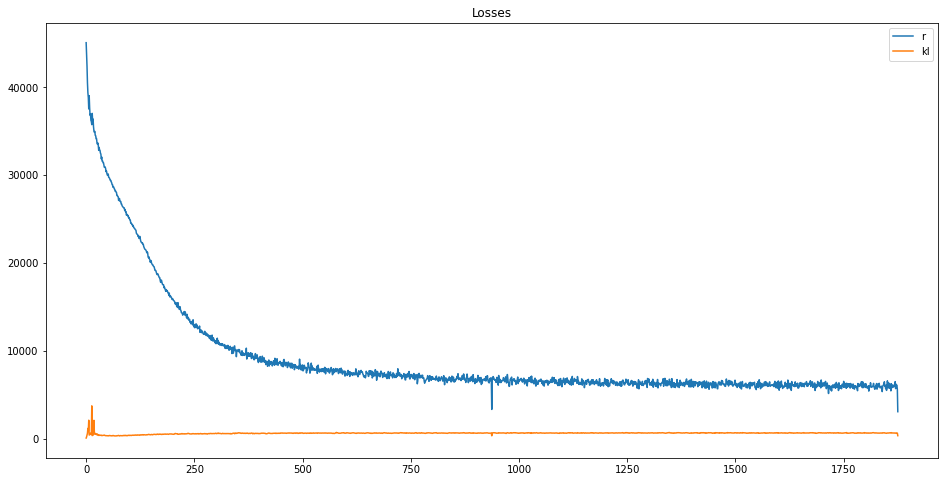

In [50]:
# plot losses
figsize(16, 8)
figure()
plot(r_losses)
plot(kl_losses)
legend(['r', 'kl'])
title("Losses")
show()

## Latent Space

Number of test encodings: 10000


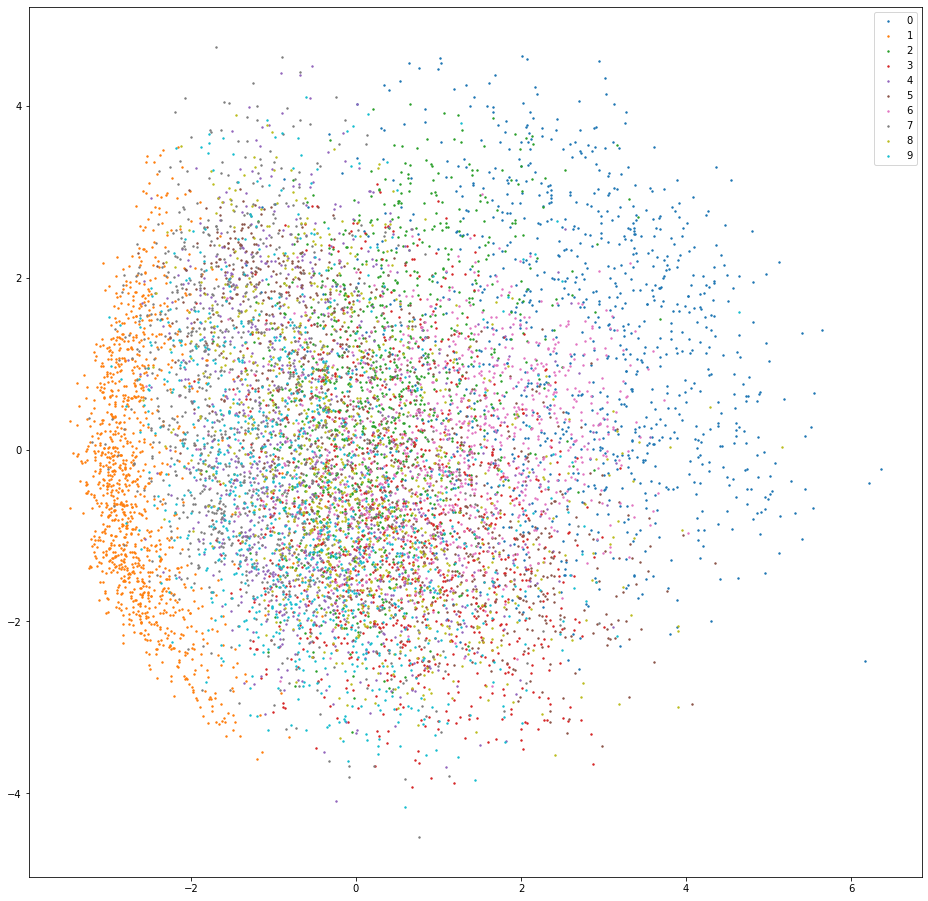

In [51]:
# build all encodings for test set
"""
    Why are there no clusters?

    The kd-loss basically tries to keep the mean near zero for all
    inputs. Thus distinguished clusters are (mostly) prohibited.
    The bigger the dimension of the latent space, the more strictly the lm-loss
    holds (this is due to the summation over the dimension. Maybe use mean instead).

    By either reducing the laten-space dimension (z-dim) or the weight for the 
    lm-loss (beta) and rerunning the notebook this will change quite drastically. 
    The different numbers will show much cleaner clusters.

    Also PCA does not help but makes things even worse. Especially when the latent
    space has many dimensions (big z-dim). 
    Maybe PCA isn't even the right thing to do in this case?
"""
vae.eval()
with torch.no_grad():
    # only interested in the mean values
    z_y = [(vae.encoder(x.to(device))[0].cpu(), y) for x, y in test_loader]
    z, test_labels = zip(*z_y)
    z, test_labels = torch.cat(z, dim=0).numpy(), torch.cat(test_labels, dim=0).numpy()
print("Number of test encodings:", z.shape[0])
# reduce dimensions
reduced_z = PCA(n_components=2).fit(z).transform(z)
# visualize code/bottleneck of different labels/numbers
figsize(16, 16)
figure()
for i in range(10):
    mask = (test_labels == i)
    scatter(reduced_z[mask, 0], reduced_z[mask, 1], s=2)
legend(range(10))
show()

## Evaluation

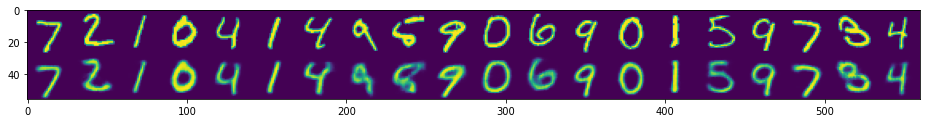

In [52]:
# visualize some example outputs
vae.eval()
with torch.no_grad():
    x = next(iter(test_loader))[0][:20].to(device)
    x_ = vae(x)[0]
# build and show image
img = torch.cat([t.cpu().transpose(0, 2).reshape(28, -1) for t in (x, x_)], dim=0).numpy()
figsize(16, 16)
figure()
imshow(img)

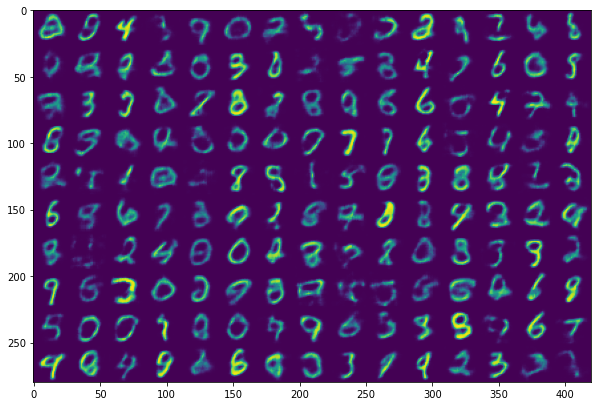

In [53]:
# deconstruct from radom
"""
    The somewhat bad results are probably due to a still to big kl loss.
    A big kl loss basically says that we should not sample from N(0, 1) 
    but from N(m, v) for some m, v. This doen't matter for interpolation, 
    which is why the interplated images are much better.
"""
n, m = 10, 15
vae.eval()
with torch.no_grad():
    z_rand = torch.empty(n * m, z_dim).normal_()
    x_ = vae.decoder.forward(z_rand.to(device))
    x_ = x_.cpu().numpy()
# build image from reconstructed
img = x_.reshape(n, m, 28, 28).transpose(0, 2, 1, 3).reshape(n * 28, m * 28)
# show
figsize(n, m)
figure()
imshow(img)
show()

## Interpolation

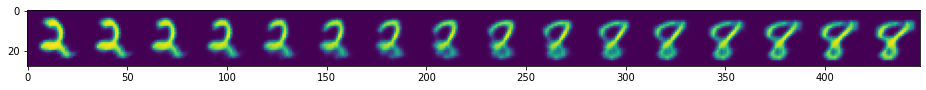

In [56]:
# interpolation between two examples
i, j = 2, 8
n = 16
# get random sample encodings from test set for i and j
zi, zj = z[test_labels == i], z[test_labels == j]
zi = zi[np.random.randint(0, zi.shape[0], size=1)]
zj = zj[np.random.randint(0, zj.shape[0], size=1)]
# interpolate a few points
t = np.linspace(0, 1, num=n).reshape(-1, 1).astype(np.float32)
z_int = zi + (zj - zi) * t
# reconstruct/decode interpolated encodings
with torch.no_grad():
    x_int = vae.decoder(torch.from_numpy(z_int).to(device))
    x_int = x_int.cpu().numpy().transpose(1, 2, 0, 3).reshape(28, n * 28)
# visualize
figsize(n, n)
figure()
imshow(x_int)
show()

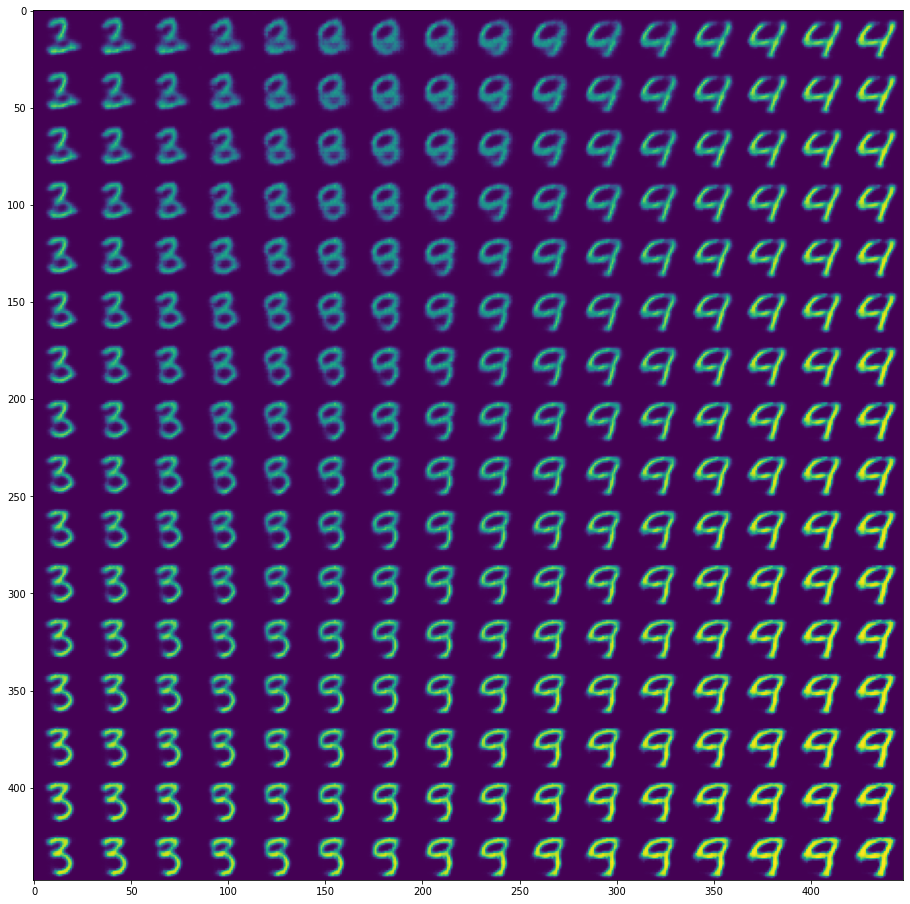

In [55]:
# interpolation between three examples
""" 
    Note that we interpolate from three examples over two dimensions.
    The interpolation plane has four corners from which 
    only three are defined by the given examples. The forth (bottom-right)
    one will be "imagenary".
    
    Nevertheless the fourth corner can have some semantic meaning.
    The bottom-right corner can be seen as the mirror element of the top-left
    when mirrored over the plane spanned by bottom-left and top-right.
    So it is the a combination of all three defined corners.
"""
i, j, k = 2, 3, 4  # top-left, bottom-left, top-right
n = 16
# get random sample encodings from test set for i and j
zi, zj, zk = z[test_labels==i], z[test_labels==j], z[test_labels==k]
zi = zi[np.random.randint(0, zi.shape[0], size=(1,))]
zj = zj[np.random.randint(0, zj.shape[0], size=(1,))]
zk = zk[np.random.randint(0, zk.shape[0], size=(1,))]
# interpolate a few points
t = np.mgrid[0:1:1/n, 0:1:1/n].transpose(1, 2, 0).reshape(n, n, 1, 2).astype(np.float32)
z_int = zi + (zj - zi) * t[..., 0] + (zk - zi) * t[..., 1]
# reconstruct/decode interpolated encodings
z_int.reshape(n * n, -1)
with torch.no_grad():
    x_int = vae.decoder(torch.from_numpy(z_int).to(device))
    x_int = x_int.cpu().numpy().reshape(n, n, 28, 28)
x_int = x_int.transpose(0, 2, 1, 3).reshape(n * 28, n * 28)
# visualize
figsize(n, n)
figure()
imshow(x_int)
show()